### Import bibliotek

In [1]:
import json
import os
import string
import morfeusz2
import numpy as np
import pandas as pd
import operator as op
import itertools as it
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import PlaintextCorpusReader
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


### Korpus dokumentów

In [2]:
corpus_dir = "./Literatura - original"
corpus = PlaintextCorpusReader(corpus_dir, r'.*\.txt')
files_names = corpus.fileids()
files_names

['arystoteles_poetyka.txt',
 'basnie_czarodzieje.txt',
 'basnie_jas_malgosia.txt',
 'basnie_kapturek.txt',
 'basnie_roszpunka.txt',
 'basnie_sniezka.txt',
 'doyle_dolina.txt',
 'doyle_pies.txt',
 'doyle_studium.txt',
 'doyle_znak.txt',
 'grabinski_ksiega.txt',
 'reymont_jesien.txt',
 'reymont_lato.txt',
 'reymont_wiosna.txt',
 'reymont_zima.txt',
 'sienkiewicz_ogniem.txt',
 'sienkiewicz_potop.txt',
 'sienkiewicz_wolodyjowski.txt',
 'wagner_banda.txt']

### Wstępne przygotowanie dokumentów

In [3]:
documents = {}
for file in files_names:
    documents[file] = corpus.raw(file)
print(json.dumps(documents, indent=4, ensure_ascii=False))

{
    "arystoteles_poetyka.txt": "Chcemy mówić o kunszcie poetyckim samym w sobie i o jego rodzajach, jakie ma znaczenie każdy z nich i jak należy układać fabułę, jeżeli poemat pięknie ma wypaść, a nadto, z ilu on i z jakich składa się części, jak również o rzeczach innych, które do tego samego zakresu badania należą, a rozpoczniemy z natury rzeczy najprzód od tego, co pierwsze. Epopeja zatem i utwór tragiczny, a nadto komedia i poezja dytyrambiczna[10], i gry na flecie i na cytrze[11] część największa — wszystkie one są, razem wziąwszy, utworami naśladowczymi, a różnią się między sobą pod trzema względami: bo albo przez to, że odmiennymi naśladują środkami, albo że naśladują co innego, albo że inaczej i nie w ten sam sposób. Podobnie bowiem jak barwami i układem postaci naśladują niektórzy sprawy rozliczne, odwzorowując je, a niektórzy za pomocą głosu, i to jedni przez sztukę, drudzy przez wprawę, tak i w wymienionych kunsztach dzieje się, że wszystkie posługują się w naśladowaniu ryt

In [4]:
stoplist_file = open("./stopwords_pl.txt", "r", encoding="utf-8")
stoplist = stoplist_file.read().splitlines()
stoplist_file.close()
stoplist = stoplist[4:]
stoplist

['vol',
 'o.o.',
 'mgr',
 'godz',
 'zł',
 'www',
 'pl',
 'ul',
 'tel',
 'hab',
 'prof',
 'inż',
 'dr',
 'i',
 'u',
 'aby',
 'albo',
 'ale',
 'ani',
 'aż',
 'bardzo',
 'bez',
 'bo',
 'bowiem',
 'by',
 'byli',
 'bym',
 'był',
 'była',
 'było',
 'były',
 'być',
 'będzie',
 'będą',
 'chce',
 'choć',
 'co',
 'coraz',
 'coś',
 'czy',
 'czyli',
 'często',
 'dla',
 'do',
 'gdy',
 'gdyby',
 'gdyż',
 'gdzie',
 'go',
 'ich',
 'im',
 'inne',
 'iż',
 'ja',
 'jak',
 'jakie',
 'jako',
 'je',
 'jednak',
 'jednym',
 'jedynie',
 'jego',
 'jej',
 'jest',
 'jeszcze',
 'jeśli',
 'jeżeli',
 'już',
 'ją',
 'kiedy',
 'kilku',
 'kto',
 'która',
 'które',
 'którego',
 'której',
 'który',
 'których',
 'którym',
 'którzy',
 'lat',
 'lecz',
 'lub',
 'ma',
 'mają',
 'mamy',
 'mi',
 'miał',
 'mimo',
 'mnie',
 'mogą',
 'może',
 'można',
 'mu',
 'musi',
 'na',
 'nad',
 'nam',
 'nas',
 'nawet',
 'nic',
 'nich',
 'nie',
 'niej',
 'nim',
 'niż',
 'no',
 'nowe',
 'np',
 'nr',
 'o',
 'od',
 'ok',
 'on',
 'one',
 'oraz',
 '

In [5]:
def lemmatize(text):
    morf = morfeusz2.Morfeusz()
    segments = it.groupby(morf.analyse(text), op.itemgetter(0, 1))
    def disambiguate(group):
        pairs = ((len(descr), lemma) 
                 for _, _, (_, lemma, descr, _, _) in group)
        perpl, lemma = min(pairs)
        return lemma.split(":")[0]
    lemmas = (disambiguate(group) for key, group in segments)
    return " ".join(filter(str.isalpha, lemmas))

In [6]:
for key in documents:
    documents[key] = documents[key].lower()
    documents[key] = "".join([char for char in documents[key] if char not in string.punctuation])
    documents[key] = lemmatize(documents[key])
    documents[key] = " ".join([word for word in word_tokenize(documents[key]) if word not in stoplist])
print(json.dumps(documents, indent=4, ensure_ascii=False))

{
    "arystoteles_poetyka.txt": "kunszt poetycki rodzaj jaki znaczenie każdy należeć układać fabuła poemat pięknie wypaść a nadto ile jaki składać część rzecz inny zakres badanie należeć a rozpocząć natura rzecz najprzód pierwszy epopeja zatem utwór tragiczny a nadto komedia poezja gra flet część duży razem wziąć utwór naśladowczy a różnić między trzy wzgląd odmienny naśladować środek naśladować inny inaczej podobnie barwa układ postać naśladować niektóry sprawa rozliczny odwzorowywać jeść a niektóry pomoc głos jednia sztuka drugi wprawa wymienić kunszt dziać posługiwać naśladować rytm słowo harmonia oddzielnie każdy połączenie druga harmonia rytm używać gra flet cytra inny sztuka rodzaj gra piszczałka pasterski rytm harmonia naśladować wielki część tancerz ruch rytmiczny naśladować charakter uczucie naśladować mowa potoczny wiersza bit bądź pomieszany druga bądź jakiś rodzaj dziać dotychczas użyć wyraz epopeja żaden inny miano wspólny objąć mim sofrona ksenarcha rozmowa sokratyczny u

### Utworzenie macierzy częstości

In [7]:
docs = pd.DataFrame.from_dict(documents, orient='index')
docs.columns = ['content']
docs

,content
arystoteles_poetyka.txt,kunszt poetycki rodzaj jaki znaczenie każdy na...
basnie_czarodzieje.txt,bieda pobożnośćpewien szewc własny wina zuboże...
basnie_jas_malgosia.txt,skraj wielki las mieszkać ubogi drwal druga żo...
basnie_kapturek.txt,mały słodki dzieweczka kochać każdy ujrzeć a d...
basnie_roszpunka.txt,mąż żona czarownica ogródżyli mąż żona długi c...
basnie_sniezka.txt,zima omenpewnego podczas srogi zima niebo sypa...
doyle_dolina.txt,musieć zastanowić zrobić dawno zauważyć Sherlo...
doyle_pies.txt,Sherlock Holmes zwyknąć wstawać późno ile czuw...
doyle_studium.txt,rok uzyskać stopień doktor medycyna uniwersyte...
doyle_znak.txt,Holmes zdjąć róg kominek flaszeczka czym safia...


In [8]:
count_vectorizer = CountVectorizer(max_df=0.8, min_df=2)
counts_tf = count_vectorizer.fit_transform(docs['content'])
counts_tf.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 4, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], shape=(19, 4784))

In [9]:
tfidf_vectorizer = TfidfVectorizer()
counts_tfidf = tfidf_vectorizer.fit_transform(docs['content'])
counts_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.00976699, 0.01953399,
        0.00976699],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(19, 11655))

### Katalogi na wyniki

In [10]:
if not os.path.exists("./wordclouds"):
    os.mkdir("./wordclouds")
if not os.path.exists("./topics"):
    os.mkdir("./topics")
if not os.path.exists("./clusters"):
    os.mkdir("./clusters")
if not os.path.exists("./ngrams"):
    os.mkdir("./ngrams")

### Chmury tagów

In [11]:
wordcloud = WordCloud(
    background_color='white',
    max_words=5000,
    contour_width=3,
    contour_color='steelblue'
)

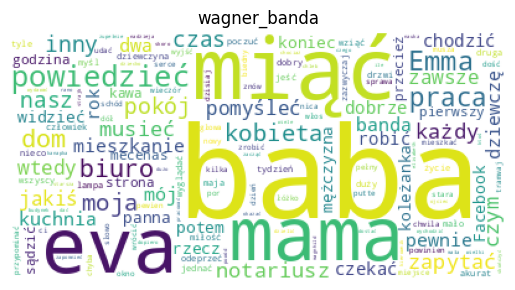

In [12]:
for index, row in docs.iterrows():
    wordcloud.generate(row['content'])
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(index.replace(".txt", ""))
    plt.savefig("./wordclouds/{}".format(index.replace(".txt", ".png")))
    

### Interpretacja Chmur Tagów
Wygenerowane chmury słów pozwalają na szybką wizualną ocenę tematyki poszczególnych tekstów. Największą czcionką reprezentowane są słowa występujące najczęściej (po usunięciu słów ze `stopwords`).
Dla analizowanych dzieł, chmury te eksponują:
- Imiona bohaterów (np. Holmes, Królowa Śnieżka, Roszpunka, Jaś, Czerwony Kapturek).
- Słownictwo charakterystyczne dla epoki lub dzieła (np. trzewik, chałupa, jaże, karzełek, baskerville, waść, waćpan).

### Topic modelling

In [13]:
def plot_top_words(model, feature_names, n_top_words, title, subplots):
    colors = ['forestgreen', 'lightskyblue', 'hotpink', 'turquoise', 'steelblue', 'crimson', 'seagreen', 'orange', 'brown', 'purple']
    fig, axes = plt.subplots(*subplots, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color=colors[topic_idx])
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig("./topics/{}.png".format(title.replace(" ", "_")))

In [14]:
def plot_documents(model, counts, n_componments, title):
    colors = ['forestgreen', 'lightskyblue', 'hotpink', 'turquoise', 'steelblue', 'crimson', 'seagreen', 'orange', 'brown', 'purple']
    docs_topic = pd.DataFrame(model.transform(counts), columns=[f'Topic {i+1}' for i in range(n_componments)])
    docs_topic.index = [file_name.replace(".txt", "") for file_name in files_names]
    plt.figure(figsize=(7, 4))
    left = [0] * len(docs_topic)
    for i, col in enumerate(docs_topic.columns):
        plt.barh(docs_topic.index, docs_topic[col], left=left, color=colors[i], label=col)
        left = [left[j] + docs_topic[col].iloc[j] for j in range(len(docs_topic))]
    plt.savefig("./topics/{}_docs.png".format(title), bbox_inches='tight')
    plt.close()

In [15]:
n_topics = 6
n_top_words = 20
feature_names = count_vectorizer.get_feature_names_out()
subplots = (2, 3)

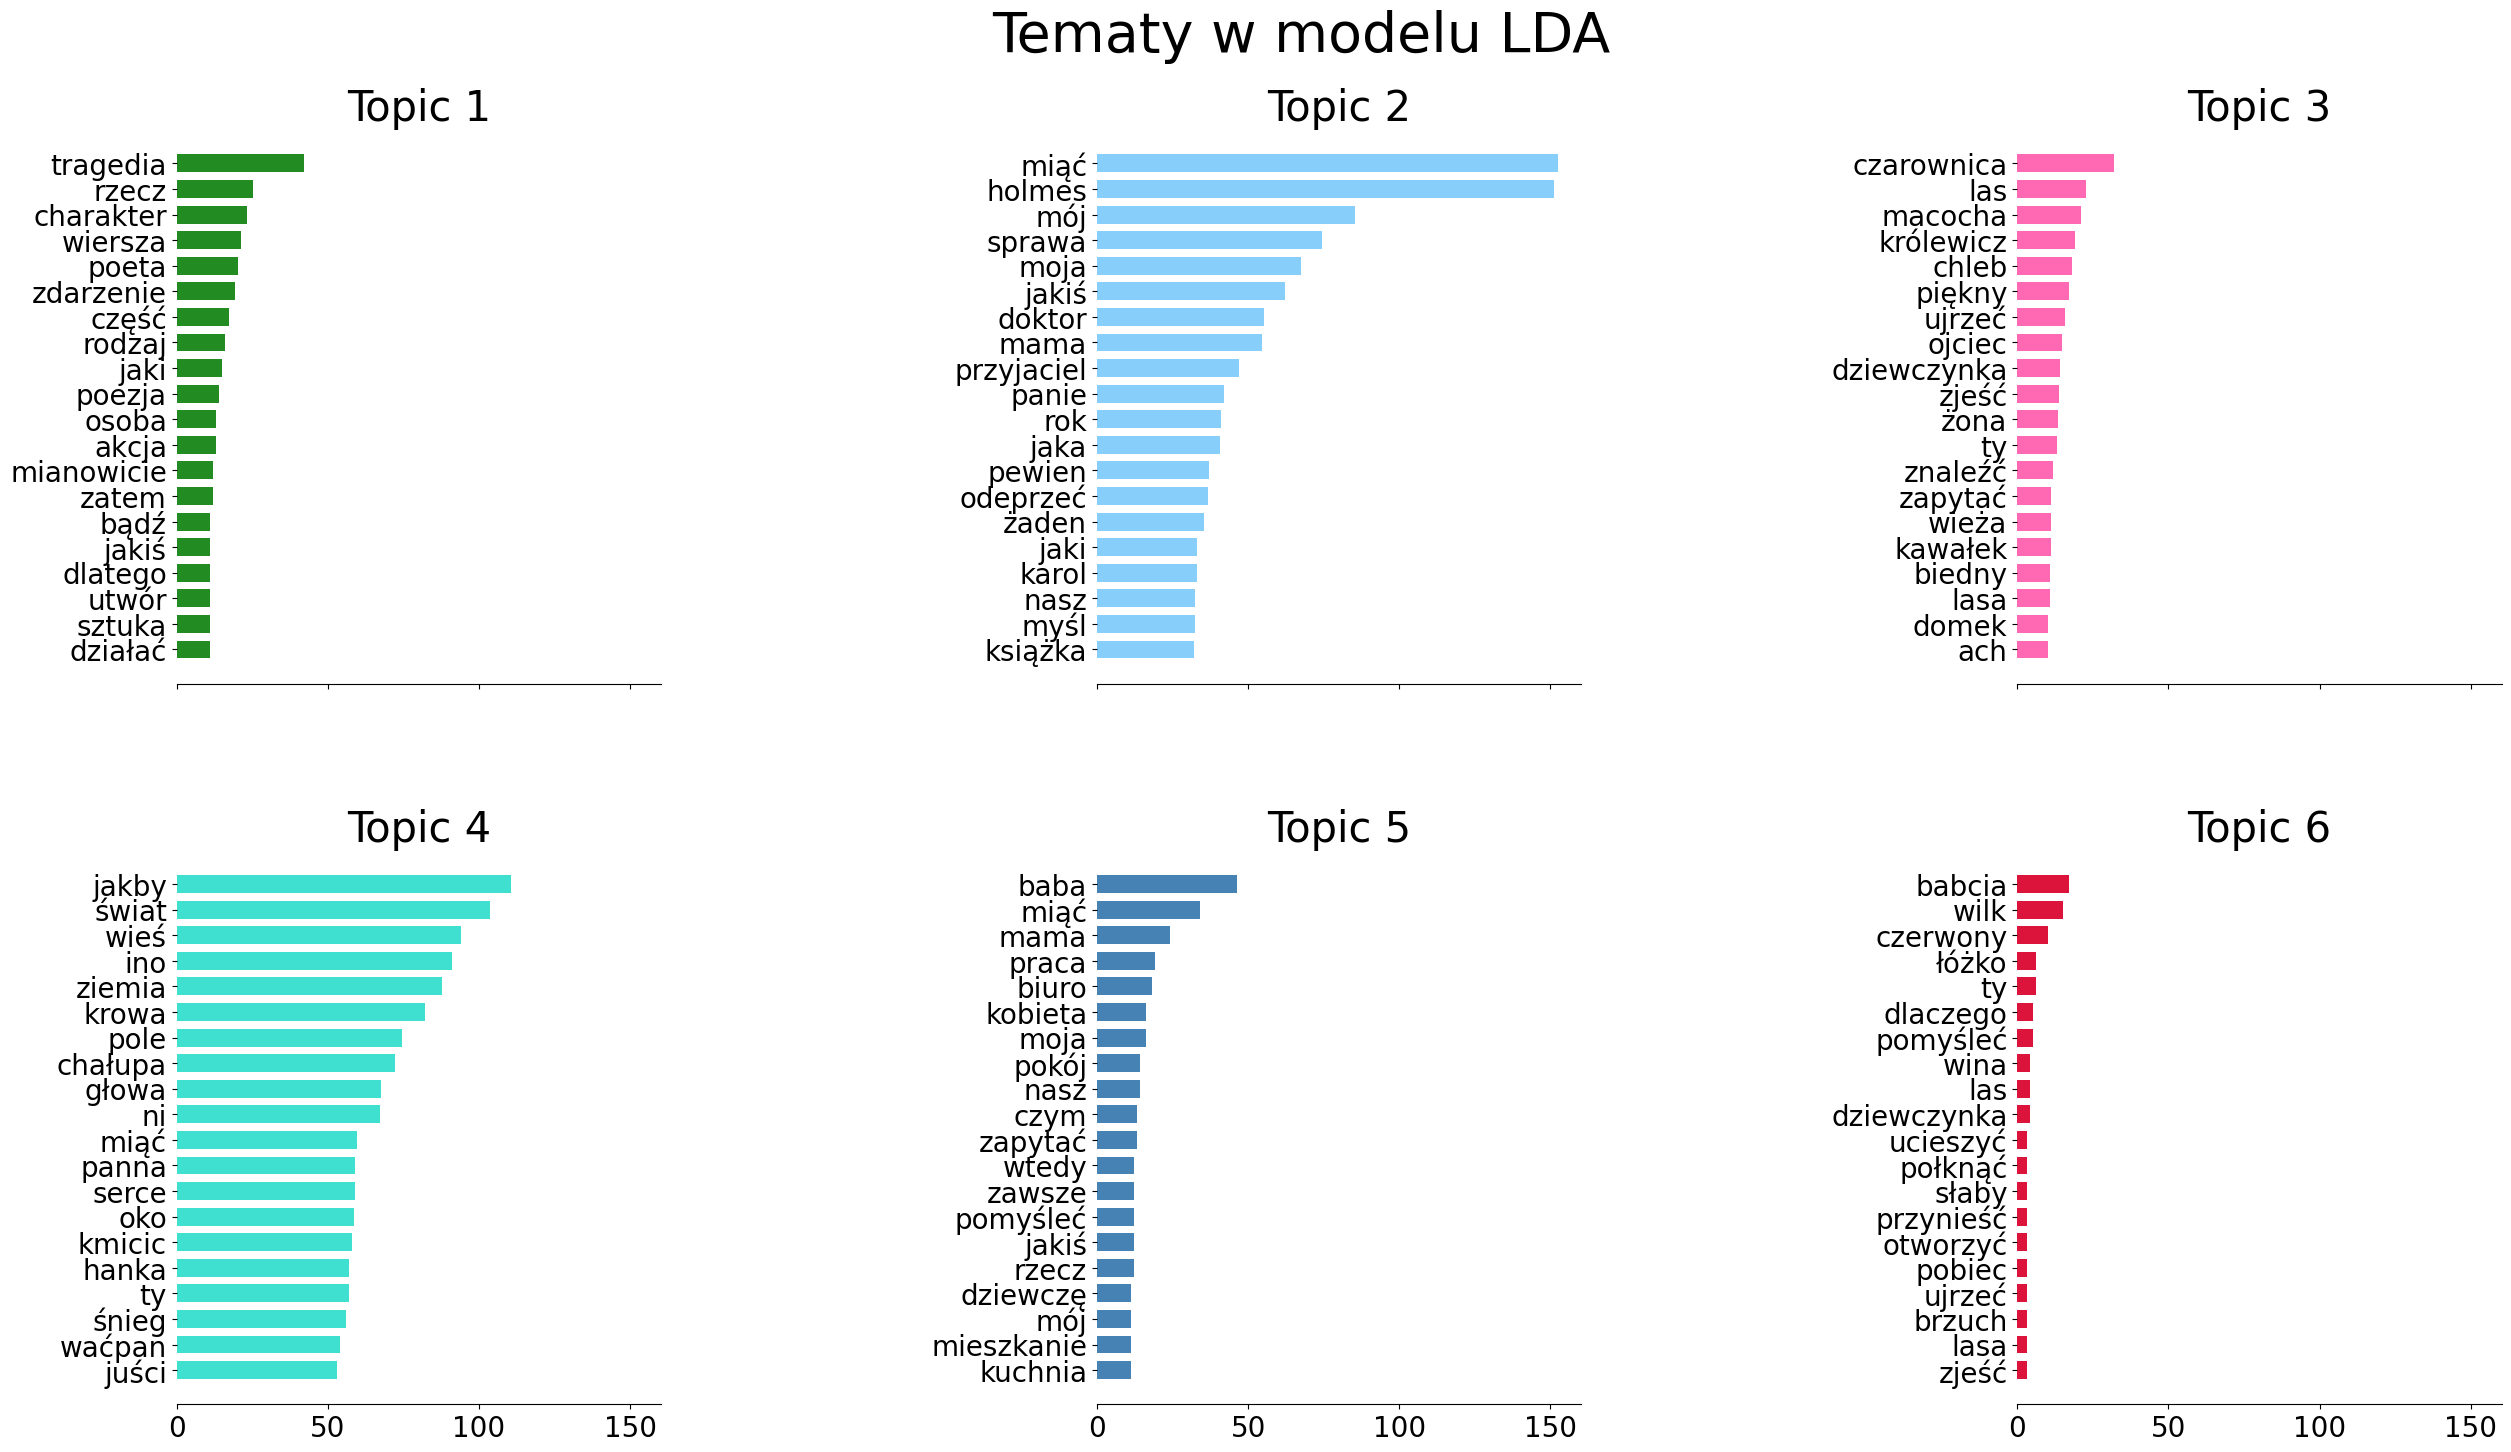

In [16]:
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=1000, learning_method="online", learning_offset=50, random_state=0)
lda.fit(counts_tf)
plot_top_words(lda, feature_names, n_top_words, "Tematy w modelu LDA", subplots)
plot_documents(lda, counts_tf, n_topics, "Tematy w modelu LDA")

### Interpretacja Modelu LDA

Model LDA (Latent Dirichlet Allocation) służy do odkrywania ukrytych struktur tematycznych w dużych zbiorach tekstów. W tym przypadku założyliśmy istnienie **6 tematów**.

Wyniki znajdują się w pliku `Tematy w modelu LDA.png` (słowa kluczowe) oraz `Tematy w modelu LDA_docs.png` (rozkład w dokumentach).

Analiza została przeprowadzona przy założeniu **6 tematów**. Poniżej przedstawiono interpretację semantyczną wyodrębnionych klastrów oraz analizę ich rozkładu w dokumentach.

### 1. Analiza słów kluczowych (Tematy)
Na podstawie najczęstszych słów w każdym temacie, można nadać im następujące etykiety:

* **Topic 1 (Teoria literatury):** Słowa takie jak *tragedia, wiersza, poeta, sztuka, utwór* jednoznacznie wskazują na tekst teoretyczno-naukowy ("Poetyka" Arystotelesa). Jest to temat bardzo hermetyczny.
* **Topic 2 (Kryminał / Narracja przygodowa):** Dominują słowa: *Holmes, doktor, sprawa, przyjaciel*. Jest to temat specyficzny dla Arthura Conan Doyle’a, skupiony na śledztwie i dialogach.
* **Topic 3 (Baśnie - archetypy):** Słowa *czarownica, macocha, królewicz, las* to klasyczne motywy baśniowe. Temat ten grupuje uniwersalne elementy fantastyczne.
* **Topic 4 (Stylizacja językowa - wieś i historia):** Ciekawe połączenie. Temat zawiera słowa gwarowe (*ino, chałupa, wieś*) oraz archaizmy (*waćpan, juści, Kmicic*). Model zgrupował tutaj teksty o silnym nacechowaniu językowym odbiegającym od współczesnej polszczyzny literackiej (Reymont i Sienkiewicz).
* **Topic 5 (Współczesna proza / Realizm):** Słowa *baba, biuro, mieszkanie, kuchnia* wskazują na bardziej przyziemną, współczesną tematykę (odpowiada tekstowi "Wagner").
* **Topic 6 (Specyficzny - Czerwony Kapturek):** Model "przeuczył się" (over-fitting) na jednym bardzo charakterystycznym tekście, tworząc osobny temat dla słów: *wilk, babcia, czerwony, kapturek*.


### 2. Rozkład tematów w dokumentach (Autorzy)
Analiza wykresu dokumentów (`_docs`) potwierdza skuteczność modelu w rozróżnianiu stylów autorskich:

1.  **Arystoteles:** 100% dopasowania do **Topic 1**. Model idealnie oddzielił tekst naukowy od beletrystyki.
2.  **Arthur Conan Doyle:** 100% dopasowania do **Topic 2**. Styl Sherlocka Holmesa jest dla modelu bardzo dystynktywny.
3.  **Władysław Reymont:** 100% dopasowania do **Topic 4**. "Chłopi" zostali bezbłędnie zaklasyfikowani do tematu "wiejskiego/stylizowanego".
4.  **Henryk Sienkiewicz:** Jego utwory są **hybrydą Topic 2 i Topic 4**.
    * Model zauważa podobieństwo językowe do Reymonta (archaizmy w Topic 4).
    * Jednocześnie struktura narracji przygodowej zbliża go do Doyle'a (Topic 2).
5.  **Baśnie:** Są niejednorodne. "Czerwony Kapturek" zdominował **Topic 6**, podczas gdy inne baśnie są mieszanką motywów ogólnobaśniowych (**Topic 3**) i stylizacji językowej.
6.  **Wagner:** Tekst ten został przypisany głównie do **Topic 5**, co wyróżnia go na tle klasyki jako literaturę o innej, prawdopodobnie nowszej strukturze słownictwa.

**Wniosek:** Model LDA poprawnie zidentyfikował główne różnice gatunkowe (nauka vs proza) oraz stylistyczne (gwara/archaizacja vs prosty język przygodowy).

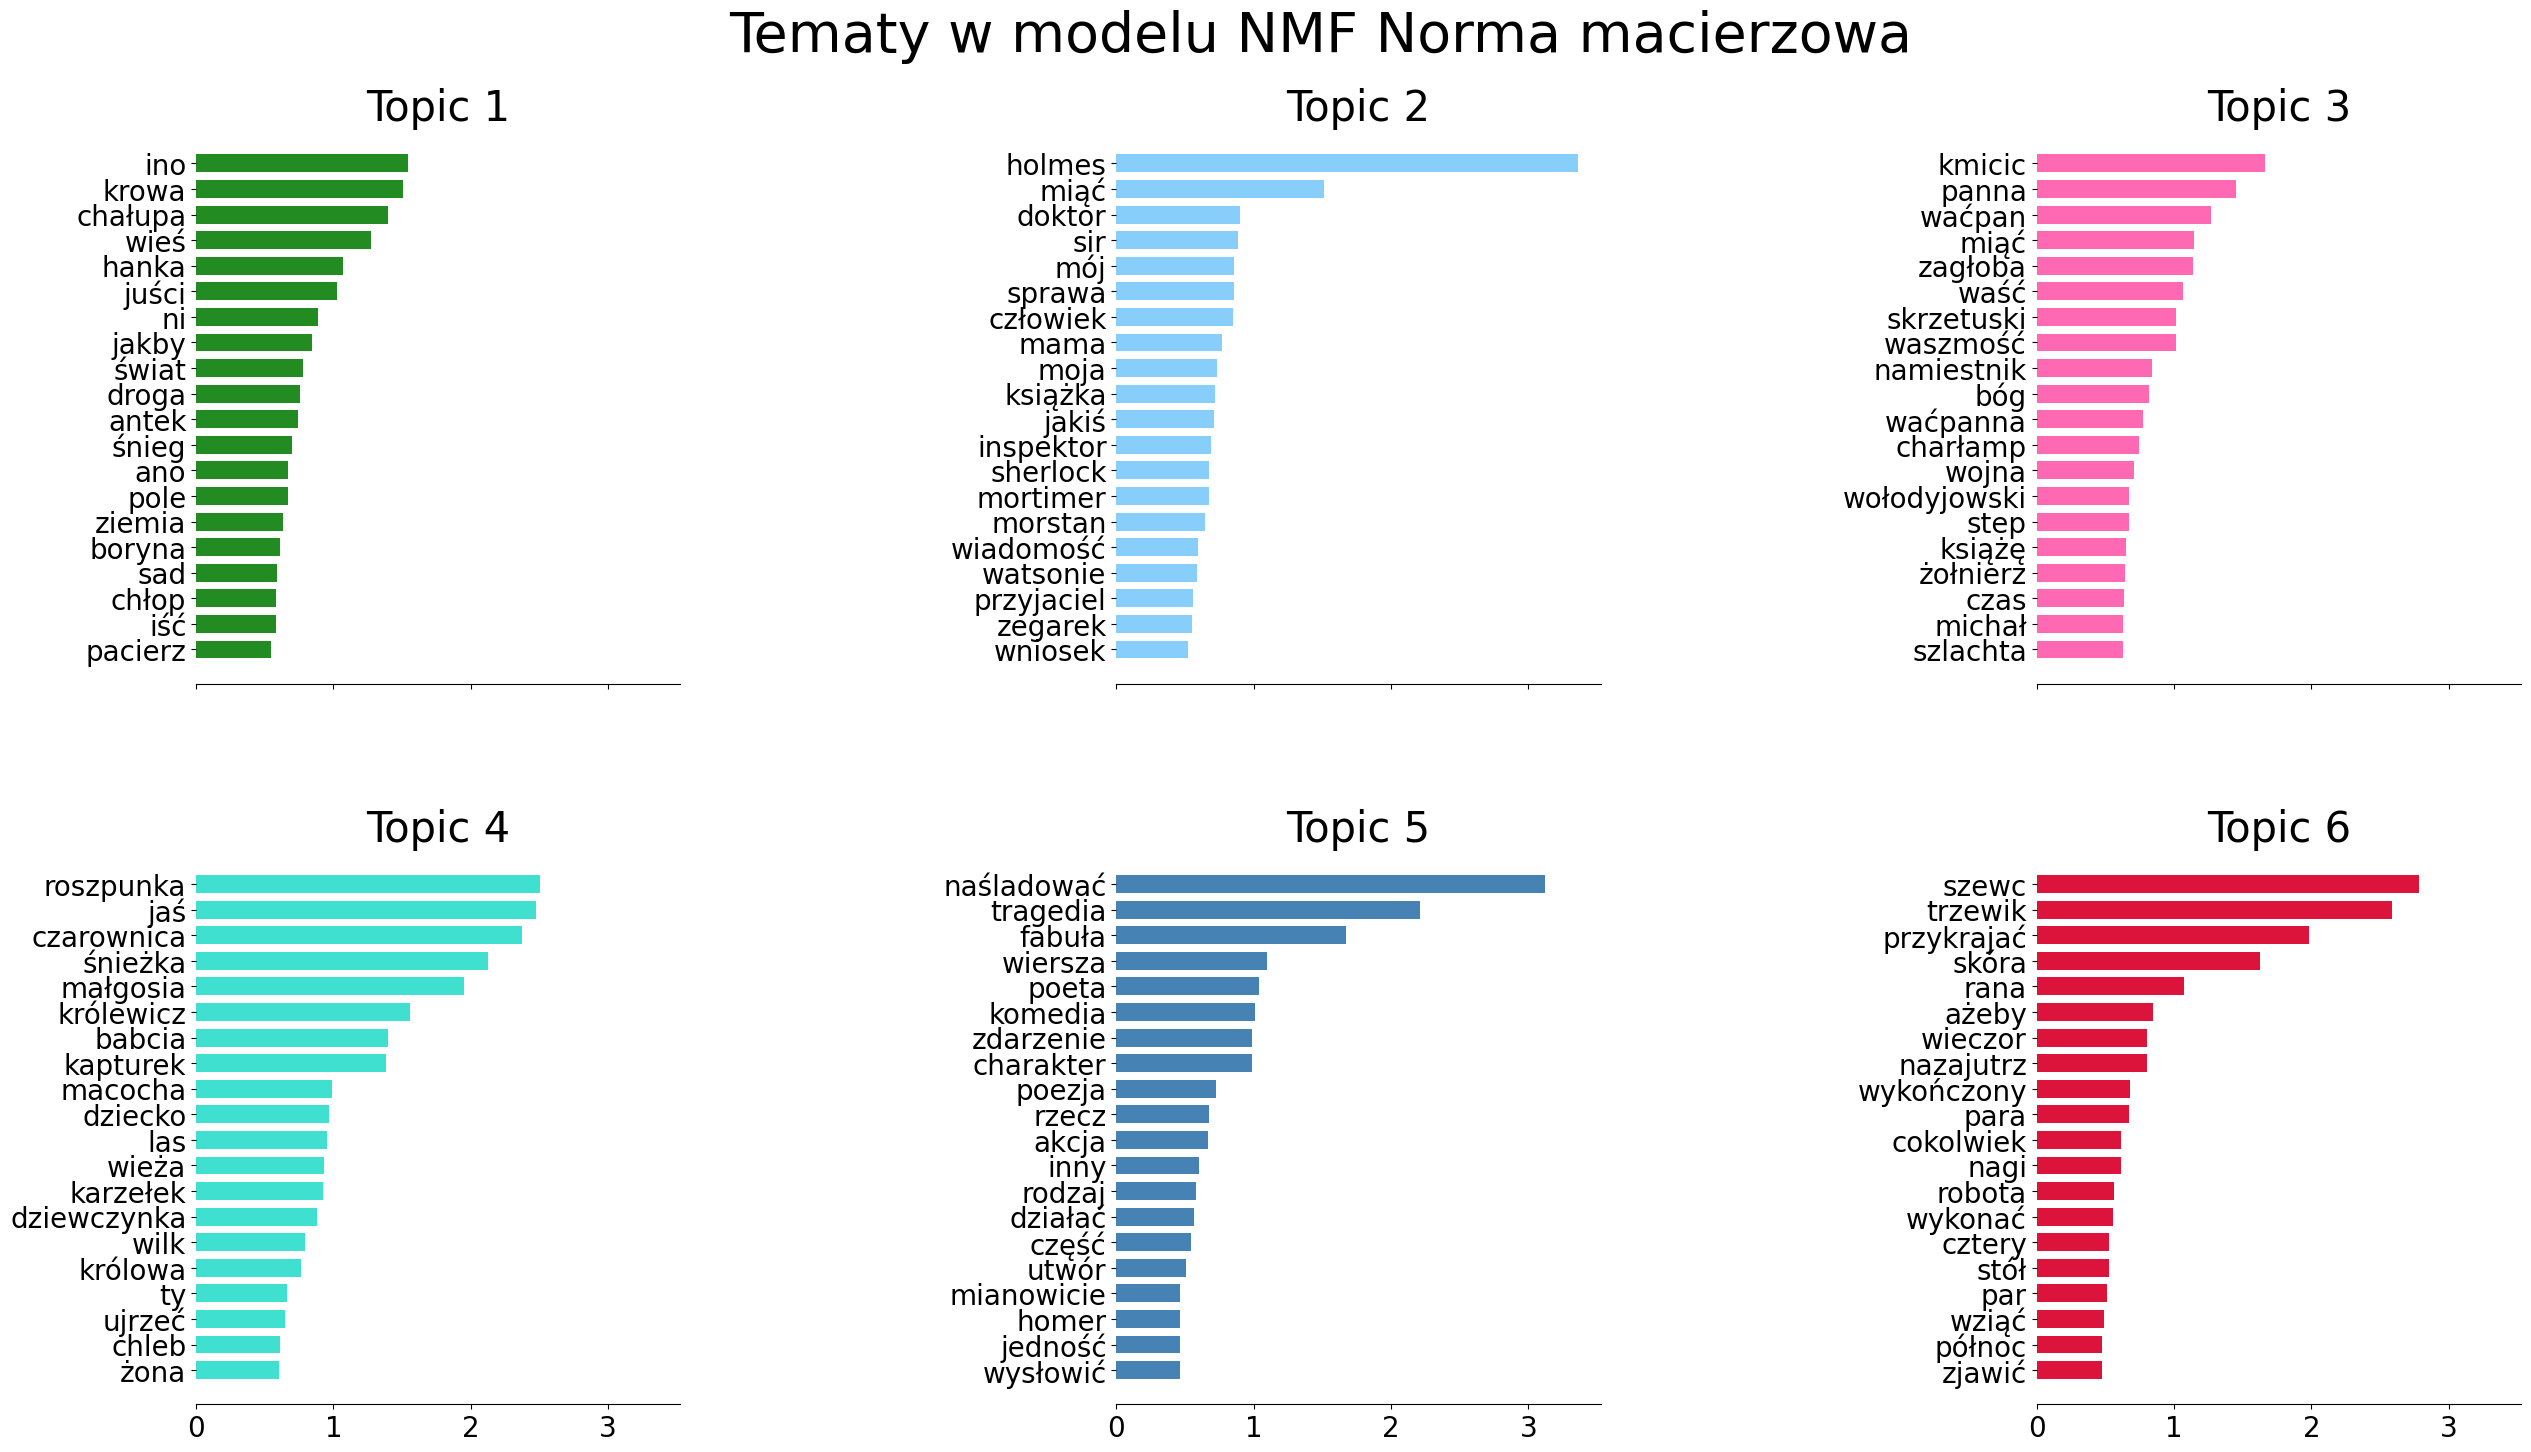

In [17]:
nmf_fn = NMF(n_components=n_topics, random_state=1, alpha_H=.00005, alpha_W=.00005, l1_ratio=.5)
nmf_fn.fit(counts_tfidf)
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
plot_top_words(nmf_fn, feature_names_tfidf, n_top_words, "Tematy w modelu NMF Norma macierzowa", subplots)
plot_documents(nmf_fn, counts_tfidf, n_topics, "Tematy w modelu NMF Norma macierzowa")

### Interpretacja Modelu NMF (Norma macierzowa)

Metoda NMF (Non-negative Matrix Factorization) wymusza, aby wszystkie elementy macierzy były nieujemne. W praktyce analizy tekstu często daje to bardziej "rozłączne" tematy niż LDA.

Poniżej znajduje się analiza wyników dla **6 tematów**.

### 1. Analiza słów kluczowych (Tematy)
Słowa kluczowe w NMF są znacznie bardziej specyficzne dla konkretnych dzieł niż w LDA:

* **Topic 1 (Ciemnozielony - Reymont):** Słowa: *ino, krowa, chałupa, wieś, hanka, juści*. To czysta gwara i tematyka wiejska. Model idealnie wyizolował język "Chłopów".
* **Topic 2 (Błękitny - Doyle):** Słowa: *holmes, doktor, sir, inspektor, watson*. Bezbłędne wyodrębnienie kryminału angielskiego.
* **Topic 3 (Różowy - Sienkiewicz):** **Kluczowa różnica względem LDA.** Tutaj mamy osobny, silny temat dla Trylogii: *kmicic, panna, waćpan, zagłoba, skrzetuski, szlachta*. NMF zauważył, że język Sienkiewicza to nie "mix", ale osobna jakość.
* **Topic 4 (Turkusowy - Baśnie):** Słowa: *roszpunka, jaś, czarownica, królewicz, kapturek*. Typowy temat baśniowy, zbierający większość bajek.
* **Topic 5 (Stalowoniebieski - Teoria):** Słowa: *naśladować, tragedia, fabuła, wiersza*. Ponownie "Poetyka" Arystotelesa została idealnie odseparowana.
* **Topic 6 (Czerwony - Specyficzny motyw):** Słowa: *szewc, trzewik, przykrajać, skóra*. Bardzo wąski temat, prawdopodobnie dotyczący konkretnej historii (np. o szewczyku lub motyw przymierzania buta w Kopciuszku), który zdominował zbiór `basnie_czarodzieje`.


### 2. Rozkład tematów w dokumentach (Autorzy)
Analiza wykresu dokumentów (`_docs`) pokazuje wyższość NMF nad LDA w zadaniu klasteryzacji autorów:

1.  **Idealna separacja "Wielkiej Trójki":**
    * **Reymont:** 100% Topic 1.
    * **Doyle:** 100% Topic 2.
    * **Sienkiewicz:** 100% Topic 3.
    * *Wniosek:* NMF poprawnie rozpoznał, że Sienkiewicz, mimo używania archaizmów (jak Reymont) i wartkiej akcji (jak Doyle), tworzy osobny, unikalny klaster stylistyczny.
2.  **Arystoteles:** 100% Topic 5. Tekst naukowy jest całkowicie odrębny od beletrystyki.
3.  **Baśnie:** Większość wpada w ogólny **Topic 4**, z wyjątkiem zbioru `basnie_czarodzieje`, który został przejęty przez specyficzny **Topic 6** (motyw szewca/butów).
4.  **Grabiński i Wagner:** Są "sierotami" w tym modelu.
    * `grabinski_ksiega` to mieszanka Reymonta (zieleń) i Sienkiewicza (róż).
    * `wagner_banda` to szum składający się z kilku tematów.

### Podsumowanie: NMF vs LDA
W tym konkretnym zbiorze danych **model NMF z normą macierzową zadziałał lepiej**.

* **LDA** sugerowało, że Sienkiewicz to hybryda Reymonta i Doyle'a.
* **NMF** poprawnie zidentyfikował Sienkiewicza jako osobny, niezależny byt stylistyczny.
* Tematy w NMF są bardziej "czyste" i ekskluzywne (mniej współwystępowania tematów w jednym dokumencie).

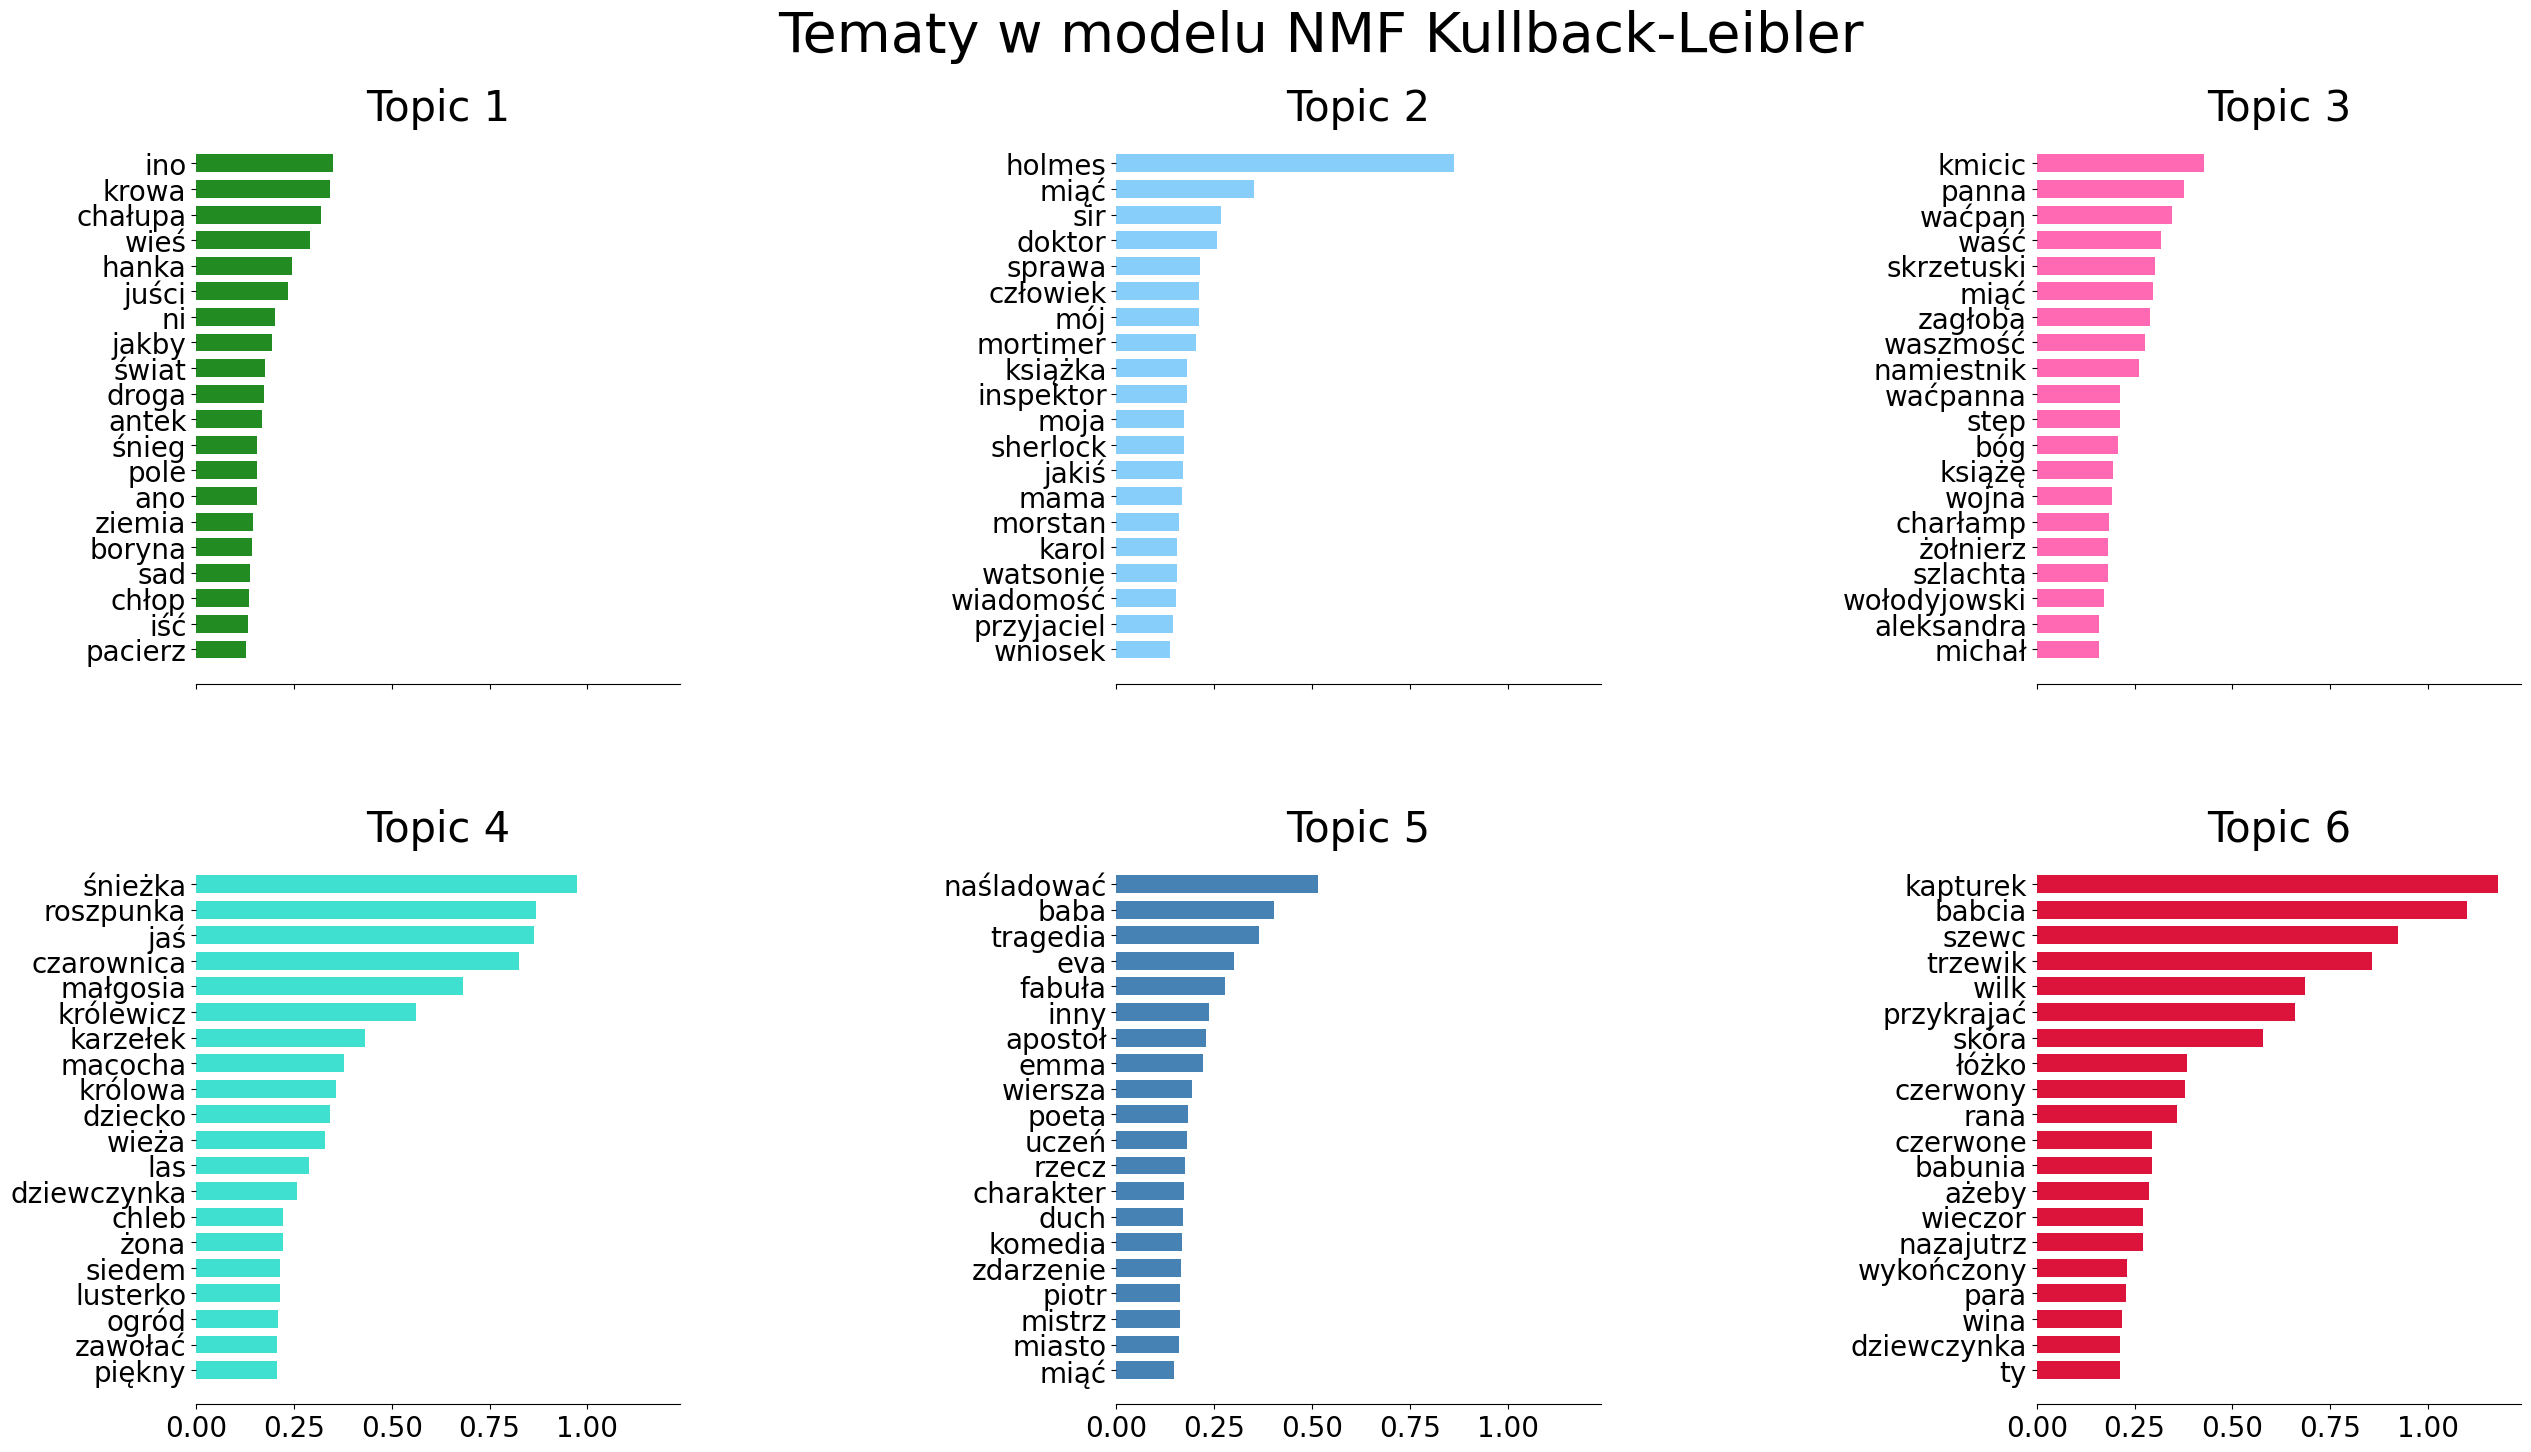

In [18]:
nmf_kl = NMF(
    n_components=n_topics,
    random_state=1,
    beta_loss='kullback-leibler',
    solver='mu',
    max_iter=1000,
    alpha_H=.00005,
    alpha_W=.00005,
    l1_ratio=.5
)
nmf_kl.fit(counts_tfidf)

plot_top_words(nmf_kl, feature_names_tfidf, n_top_words, "Tematy w modelu NMF Kullback-Leibler", subplots)
plot_documents(nmf_kl, counts_tfidf, n_topics, "Tematy w modelu NMF Kullback-Leibler")

### Interpretacja Modelu NMF (Dywergencja Kullbacka-Leiblera)

Wariant NMF minimalizujący dywergencję Kullbacka-Leiblera (KL) jest matematycznie zbliżony do metod probabilistycznych (jak PLSA). Traktuje teksty bardziej jako rozkłady prawdopodobieństwa słów, co sprawia, że wyniki często stanowią **kompromis między klasycznym LDA a NMF z normą euklidesową**.

### 1. Analiza słów kluczowych (Tematy)
Model z dywergencją KL wygenerował tematy, które są bardzo "ostre" dla głównych autorów, ale stworzył też specyficzny "worek" dla pozostałych tekstów.

* **Topic 1 (Ciemnozielony - Reymont):** Słowa *ino, krowa, chałupa, wieś*. Podobnie jak w poprzednich modelach, gwara "Chłopów" jest bardzo silnym wyróżnikiem.
* **Topic 2 (Błękitny - Doyle):** Słowa *holmes, sir, doktor, watson*. Stabilny i czysty temat kryminalny.
* **Topic 3 (Różowy - Sienkiewicz):** Słowa *kmicic, panna, waćpan, zagłoba*. NMF KL (podobnie jak zwykły NMF) świetnie radzi sobie z wyodrębnieniem Sienkiewicza jako osobnego stylu, nie mieszając go z Doyle'em (co robiło LDA).
* **Topic 4 (Turkusowy - Baśnie ogólne):** Słowa *śnieżka, roszpunka, jaś, czarownica, królewicz*. Bardzo czysty temat zbierający klasyczne postacie bajkowe.
* **Topic 5 (Stalowoniebieski - "Inne" / Literacki mix):** To najciekawszy temat w tym modelu. Zawiera słowa naukowe (*naśladować, tragedia, fabuła* - Arystoteles) zmieszane ze słowami z innej prozy (*baba, eva, emma* - Wagner/Grabiński). Jest to temat "reszty", zbierający teksty napisane standardową polszczyzną, bez gwary czy archaizmów.
* **Topic 6 (Czerwony - Baśnie specyficzne):** Słowa *kapturek, babcia, szewc, trzewik*. Model wydzielił osobny temat dla baśni o Czerwonym Kapturku oraz motywu butów (Kopciuszek/Szewczyk).


### 2. Rozkład tematów w dokumentach (Autorzy)
Wykres dokumentów (`_docs`) ujawnia specyfikę podejścia Kullbacka-Leiblera:

1.  **Silna separacja głównych stylów:**
    * **Reymont, Doyle i Sienkiewicz** mają swoje dedykowane tematy (odpowiednio T1, T2, T3). Widać tu przewagę nad LDA - Sienkiewicz jest monolitem.
2.  **Zjawisko "zlania się" mniejszych autorów (Topic 5):**
    * W przeciwieństwie do LDA (gdzie Arystoteles miał swój własny temat), tutaj **Arystoteles ("Poetyka"), Grabiński ("Księga Ognia") i Wagner** zostali wrzuceni do jednego worka (Topic 5).
    * **Interpretacja:** Dla miary KL rozkłady słów w tych trzech tekstach są do siebie bardziej podobne (standardowa polszczyzna literacka/naukowa) niż do silnie nacechowanych stylistycznie tekstów Reymonta (gwara) czy Sienkiewicza (archaizmy).
3.  **Podział Baśni:**
    * Model bardzo wyraźnie podzielił baśnie na dwie grupy: typowe historie o księżniczkach (Topic 4) oraz te oparte na innych motywach (Topic 6 - Kapturek/Szewc).

### Wnioski końcowe
Model NMF (KL) zadziałał jako **"agresywny separator stylu"**:
* Perfekcyjnie oddzielił teksty o silnym nacechowaniu językowym (gwara, archaizmy, angielskie realia, prosty język baśni).
* Teksty "neutralne" lub "trudne" (Wagner, Grabiński, Arystoteles) zgrupował razem, uznając, że są do siebie bardziej podobne niż do reszty korpusu.

### Analiza skupień

In [19]:
def plot_dendrogram(model,title, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)
    plt.title(title)
    plt.savefig("./clusters/{}.png".format(title.replace(" ", "_")), bbox_inches='tight')
    plt.close()

In [20]:
cs = cosine_distances(counts_tfidf, counts_tfidf).flatten().reshape(len(files_names), len(files_names))
ed = euclidean_distances(counts_tfidf, counts_tfidf).flatten().reshape(len(files_names), len(files_names)) 

In [21]:
clustering_ed_complete = AgglomerativeClustering(
    n_clusters=3,
    metric='precomputed',
    linkage='complete',
    compute_distances=True,
).fit(ed)

plot_dendrogram(
    clustering_ed_complete,
    title="Dendrogram - odległość euklidesowa, metoda pełnego wiązania", 
    labels=[file_name.replace(".txt", "") for file_name in files_names], 
    orientation='left'
)
clustering_ed_complete.labels_


array([1, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Interpretacja Dendrogramu (Odległość euklidesowa, metoda pełnego wiązania)

Dendrogram wizualizuje hierarchiczne grupowanie dokumentów (Hierarchical Clustering). Oś pozioma reprezentuje odległość (różnicę) między tekstami – im bliżej prawej strony następuje połączenie, tym teksty są bardziej do siebie podobne. Im dalej w lewo (wyższa wartość na osi X), tym większa różnica.

### 1. Podstawowe grupy (Klastry autorskie)
Algorytm perfekcyjnie odtworzył podział na autorów. Widzimy cztery wyraźne, zwarte bloki ("gałęzie"):

* **Sienkiewicz (Góra):** *Wołodyjowski, Potop, Ogniem i Mieczem* łączą się ze sobą bardzo wcześnie (mała odległość), co świadczy o wysokiej spójności stylu Trylogii.
* **Reymont:** Cztery części "Chłopów" (*Wiosna, Lato, Zima, Jesień*) tworzą kolejny zwarty klaster.
* **Doyle:** Opowiadania o Sherlocku Holmesie (*Znak, Studium, Dolina, Pies*) są silnie zgrupowane razem.
* **Baśnie:** Wszystkie baśnie (*Czarodzieje, Roszpunka, Jaś i Małgosia, Śnieżka, Kapturek*) tworzą osobną, silną gałąź na dole wykresu.

### 2. Relacje międzygrupowe (Wyższy poziom abstrakcji)
Patrząc na to, jak łączą się większe gałęzie (przesuwając się w lewo), możemy wyciągnąć wnioski o podobieństwie stylów:

* **Sienkiewicz + Reymont:** Te dwie grupy łączą się ze sobą najpierw. Oznacza to, że pod względem słownictwa (odległość euklidesowa wektorów częstości) Trylogia jest najbliższa "Chłopom".
    * *Interpretacja:* Oba korpusy używają bogatej, specyficznej polszczyzny (archaizmy u Sienkiewicza, gwara u Reymonta), co odróżnia je od prostszego języka przekładów Doyle'a czy Baśni.
* **Grabiński:** Został "doklejony" do klastra Reymonta. Sugeruje to bogaty język literacki, bliższy klasyce polskiej niż tłumaczeniom.
* **Wagner + Doyle:** Tekst *Wagner_banda* został przyłączony do klastra Doyle'a. Może to wynikać z tematyki (akcja/przygoda) lub struktury języka (współczesna, standardowa polszczyzna, podobnie jak w tłumaczeniach Holmesa).

### 3. Outsider (Arystoteles)
* **Arystoteles_poetyka** (na samym dole) jest "samotną wyspą".
* Łączy się z resztą drzewa jako **ostatni element**, przy największej odległości (ok. 1.4).
* *Wniosek:* Jest to tekst najbardziej odmienny od wszystkich innych w zbiorze. Potwierdza to wcześniejsze wyniki LDA/NMF - język teorii literatury (słownictwo abstrakcyjne) jest matematycznie bardzo daleki od języka beletrystyki.

### Podsumowanie
Dendrogram oparty na odległości euklidesowej okazał się **bardzo skuteczny**. Nie tylko bezbłędnie pogrupował tomy tych samych serii, ale również logicznie połączył autorów o podobnej specyfice językowej (polska klasyka vs. literatura tłumaczona/prostsza).

In [22]:
clustering_cs_ward= AgglomerativeClustering(
    n_clusters=3,
    metric='euclidean',
    linkage='ward',
    compute_distances=True,
).fit(cs)

plot_dendrogram(
    clustering_cs_ward,
    title="Dendrogram - odległość kątowa, łączenie ward", 
    labels=[file_name.replace(".txt", "") for file_name in files_names], 
    orientation='left'
)
clustering_ed_complete.labels_


d:\Studia\Katarzyna Wójcik\MetodyAnalizyTekstuZaliczenie\.venv\Lib\site-packages\scipy\cluster\hierarchy.py:810: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([1, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Interpretacja Dendrogramu (Odległość kątowa, metoda Warda)

W tym podejściu wykorzystano **odległość kątową (kosinusową)**, która mierzy "kąt" między wektorami tekstów. Oznacza to, że **długość tekstu nie ma znaczenia** - liczy się tylko struktura i proporcje użytych słów. Metoda Warda minimalizuje wariancję wewnątrz klastrów, dążąc do tworzenia zwartych grup.

### 1. Główne podziały (Topologia drzewa)
Drzewo dzieli się na dwie główne gałęzie (na poziomie odległości ok. 2.5):
1.  **Dolna gałąź (Doyle + Reymont):** Grupuje teksty o najbardziej specyficznym, wyróżniającym się języku (tłumaczenie z angielskiego oraz gwara chłopska).
2.  **Górna gałąź (Czerwona - "Super-klaster"):** Zbiera całą resztę: Sienkiewicza, Baśnie, Literaturę "wysoką" (Wagner, Grabiński) oraz... Arystotelesa.

### 2. Szczegółowa analiza klastrów

* **Reymont (Pomarańczowy) i Doyle (Zielony):**
    * Nadal tworzą perfekcyjnie odseparowane, zwarte podgrupy.
    * Ciekawostka: W odległości kątowej te dwie grupy są sobie bliższe (łączą się ze sobą) niż z resztą korpusu. Może to sugerować, że są to teksty najbardziej "gatunkowe" i odległe od standardowej polszczyzny literackiej (jeden przez gwarę, drugi przez specyfikę przekładu).

* **Sienkiewicz (Część klastra Czerwonego):**
    * **Istotna zmiana:** W odległości euklidesowej Sienkiewicz był blisko Reymonta. Tutaj Sienkiewicz został wciągnięty do "dużego worka" (czerwony klaster) razem z Baśniami i inną prozą.
    * *Interpretacja:* Po znormalizowaniu długości tekstu, archaizmy Sienkiewicza nie ważą tak dużo, by wypchnąć go do osobnej grupy. Jego struktura narracyjna (profil słownictwa) okazuje się zbliżona do ogólnej prozy i baśni.

* **Baśnie:**
    * Większość baśni (*Roszpunka, Jaś, Śnieżka, Kapturek*) tworzy zwartą podgrupę wewnątrz czerwonego klastra.
    * Wyjątkiem jest `basnie_czarodzieje`, który "uciekł" do grupy "literackiej" (wyżej).

* **Grupa "Standardowa Polszczyzna" (Góra wykresu):**
    * Tutaj widzimy największe przetasowanie. Teksty: `wagner_banda`, `grabinski_ksiega` oraz `arystoteles_poetyka` lądują razem.
    * **Fenomen Arystotelesa:** W odległości euklidesowej był absolutnym outsiderem. W odległości kątowej pasuje do Wagnera i Grabińskiego.
    * *Wniosek:* Arystoteles różni się od reszty głównie **liczebnością** słownictwa (co pokazał Euklides), ale jego **profil** (proporcje słów typowych dla języka ogólnego) jest zbliżony do innej literatury pisanej standardową polszczyzną (bez gwary czy stylizacji).

### Podsumowanie: Euklides vs Kątowa
* **Odległość Euklidesowa** lepiej wyłapuje różnice wynikające z "bogactwa" słownictwa (dlatego łączyła "bogatego" Sienkiewicza z "bogatym" Reymontem i wyrzucała "innego" Arystotelesa).
* **Odległość Kątowa** lepiej grupuje teksty pod względem "tematu/gatunku" (dlatego łączy Sienkiewicza z inną prozą fabularną, a Arystotelesa przytula do tekstów pisanych standardowym językiem, izolując mocno nacechowanego gwarowo Reymonta).

### N-gramy

In [23]:
documents_tokenized = {}
for key in documents:
    documents_tokenized[key] = word_tokenize(documents[key], language='polish')
print(json.dumps(documents_tokenized, indent=4, ensure_ascii=False))

{
    "arystoteles_poetyka.txt": [
        "kunszt",
        "poetycki",
        "rodzaj",
        "jaki",
        "znaczenie",
        "każdy",
        "należeć",
        "układać",
        "fabuła",
        "poemat",
        "pięknie",
        "wypaść",
        "a",
        "nadto",
        "ile",
        "jaki",
        "składać",
        "część",
        "rzecz",
        "inny",
        "zakres",
        "badanie",
        "należeć",
        "a",
        "rozpocząć",
        "natura",
        "rzecz",
        "najprzód",
        "pierwszy",
        "epopeja",
        "zatem",
        "utwór",
        "tragiczny",
        "a",
        "nadto",
        "komedia",
        "poezja",
        "gra",
        "flet",
        "część",
        "duży",
        "razem",
        "wziąć",
        "utwór",
        "naśladowczy",
        "a",
        "różnić",
        "między",
        "trzy",
        "wzgląd",
        "odmienny",
        "naśladować",
        "środek",
        "naśladować",
     

In [24]:
for n in range(1, 4):
    fig, axes = plt.subplots(4, 5, figsize=(30, 15), tight_layout=True)
    axes = axes.flatten()
    for i, key in enumerate(documents_tokenized):
        if i < len(axes):
            n_grams = pd.Series(ngrams(documents_tokenized[key], n)).value_counts()
            n_grams[:5].plot.barh(ax=axes[i], title="{}-gramy w {}".format(n, key.replace(".txt", "")))
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.savefig("./ngrams/{}-grams.png".format(n), bbox_inches="tight")
    plt.close()

## Interpretacja N-gramów (Częstość występowania fraz)

Analiza N-gramów pozwala spojrzeć na strukturę tekstu na trzech poziomach: słownictwa (1-gramy), kolokacji (2-gramy) i dłuższych fraz (3-gramy). Poniżej przedstawiono wnioski dla poszczególnych autorów.

### 1. 1-gramy (Najczęstsze słowa - Unigramy)
Wykresy 1-gramów potwierdzają skuteczność wcześniejszego modelowania tematycznego (LDA/NMF):

* **Henryk Sienkiewicz:** Dominują nazwiska bohaterów (*Kmicic, Skrzetuski*) oraz specyficzne zwroty adresatywne (*waćpan*). Słowa te nadają tekstowi silny rys historyczny.
* **Władysław Reymont:** Wyróżnia się słownictwem gwarowym i wiejskim (*ino, chałupa, wieś, ziemia*). Co ciekawe, w "Chłopach" (np. *reymont_jesien*) bardzo wysoko jest słowo *droga* i *iść*, co oddaje dynamikę przemieszczania się po wsi.
* **Arthur Conan Doyle:** Tutaj królują tytuły i nazwiska (*Holmes, doktor, sir*). Jest to typowe dla literatury angielskiej tamtego okresu, gdzie hierarchia i formalność są kluczowe.
* **Baśnie:** Dominują archetypy (*królewicz, czarownica, babcia*). Widać też specyficzne dla danej bajki słowa-klucze (np. *szewc, trzewik, skóra* w `basnie_czarodzieje`).
* **Arystoteles:** Słownictwo abstrakcyjne (*tragedia, naśladować, fabuła*).

### 2. 2-gramy (Pary słów - Bigramy)
Analiza bigramów ujawnia styl łączenia słów i tytułowania:

* **Doyle - Siła marki:** Najsilniejsze bigramy to pełne imiona i nazwiska lub tytuły: *Sherlock Holmes, doktor Mortimer, sir Henryka, panie Holmes*. Autor rzadko używa samego imienia, co buduje dystans i atmosferę kryminału.
* **Sienkiewicz - Etykieta szlachecka:** Widać wyraźne formy grzecznościowe: *mości namiestnik, panna Aleksandra, Andrzej Kmicic*. Charakterystyczne jest łączenie tytułu z funkcją lub imieniem.
* **Baśnie - Stałe atrybuty:** Baśnie operują stałymi zbitkami słownymi: *czerwony kapturek, siedem karzełek*. Przymiotnik jest tu nierozerwalnie związany z rzeczownikiem (epitet stały).
* **Reymont - Specyfika składni:** Widać pary typu *dobry słowo, każdy chałupa*.
    * *Uwaga techniczna:* Widoczna jest tutaj **lematyzacja** (sprowadzenie do formy podstawowej). W oryginale byłoby "dobre słowo", ale algorytm sprowadził przymiotnik do mianownika rodzaju męskiego.

### 3. 3-gramy (Dłuższe frazy - Trigramy)
Trigramy pokazują "gotowe klocki", z których autorzy budują narrację:

* **Doyle:** *sir Karol Baskerville, doktor Jakub Mortimer*. Widać tu pedantyczną dokładność w określaniu tożsamości postaci.
* **Sienkiewicz:** *poprawić szlachcic jedno, wnuczka moja Aleksandra*. Są to fragmenty dialogów stylizowanych na mowę potoczną XVII wieku.
* **Baśnie:** Całe fragmenty akcji lub opisu postaci: *czerwony kapturek wilk, siedem karzełek zapukać*. W baśniach frazy te służą do szybkiego przywołania znanych obrazów.
* **Arystoteles:** *tragedia naśladować akcja*. To esencja definicji tragedii antycznej (mimesis).

### Podsumowanie techniczne (Preprocessing)
Analizując N-gramy, warto zwrócić uwagę na jakość preprocessingu:
1.  **Lematyzacja:** Działa poprawnie (słowa są w formach podstawowych), co widać np. po frazie *cztery para* zamiast *cztery pary*.
2.  **Stopwords:** W niektórych bigramach (np. u Sienkiewicza *a potem*, u Reymonta *ni drzewo ni*) pojawiają się spójniki (*a, ni*). Sugeruje to, że lista słów do usunięcia (stopwords) mogłaby zostać poszerzona, choć z drugiej strony partykuła "ni" jest istotnym elementem stylizacji Reymonta.

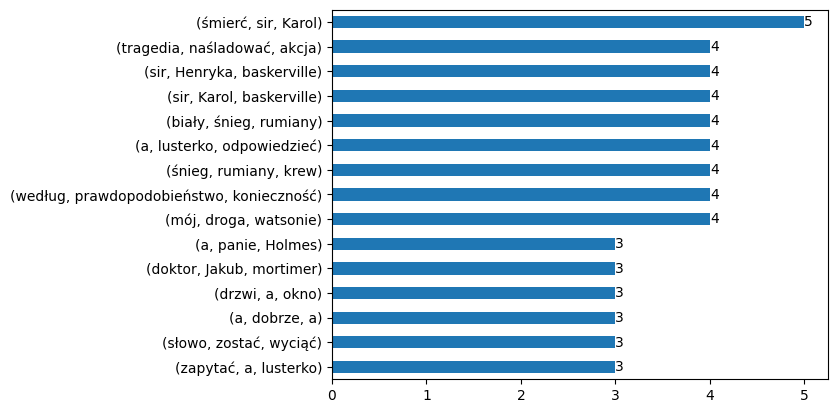

In [25]:
texts = " ".join(docs['content']).split(" ")
n_grams = pd.Series(ngrams(texts, 3)).value_counts()
ax = n_grams[:15].plot.barh()
plt.gca().invert_yaxis()
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

## Interpretacja N-gramów (Ujęcie Globalne)

Analiza globalna najczęstszych trójek słów (3-gramów) w całym korpusie ujawnia, które teksty są najbardziej powtarzalne strukturalnie. Wykres wskazuje na dominację trzech specyficznych stylów, które "przykryły" resztę literatury.

### 1. Dominacja tytułów i nazwisk (Arthur Conan Doyle)
Na szczycie listy globalnej znajdują się frazy związane z "Psem Baskerville'ów":
* *(śmierć, sir, Karol)*
* *(sir, Henryka, baskerville)*
* *(sir, Karol, baskerville)*

**Wniosek:** Proza detektywistyczna (szczególnie w tłumaczeniu) cechuje się sztywnością w nazywaniu postaci. Tytuł "Sir" jest nieodłączny od nazwiska, co sztucznie podbija statystyki N-gramów. Dodatkowo widzimy kultową frazę: *(mój, droga, watsonie)*, która jest wizytówką tego autora.

### 2. Definicje naukowe (Arystoteles)
Wysoko w rankingu znalazły się frazy z "Poetyki":
* *(tragedia, naśladować, akcja)*
* *(według, prawdopodobieństwo, konieczność)*

**Wniosek:** Tekst naukowy/filozoficzny opiera się na precyzyjnych definicjach. Arystoteles wielokrotnie powtarza te same sekwencje słów, aby utrwalić pojęcia (mimesis, zasada prawdopodobieństwa). W przeciwieństwie do powieści, gdzie unika się powtórzeń, w nauce są one pożądane.

### 3. Baśniowe refreny (Królewna Śnieżka)
Trzecią silną grupą są frazy z baśni:
* *(biały, śnieg, rumiany)*
* *(a, lusterko, odpowiedzieć)*

**Wniosek:** Baśnie korzystają z **epitetów stałych** (śnieg zawsze jest biały, a krew rumiana) oraz **powtórzeń magicznych** (dialog z lusterkiem). To cecha literatury wywodzącej się z tradycji ustnej – powtarzalne frazy ułatwiają zapamiętywanie historii.

### Podsumowanie: Gdzie są Sienkiewicz i Reymont?
W ujęciu globalnym zabrakło w czołówce Sienkiewicza i Reymonta, mimo że mają bogate słownictwo (co pokazały dendrogramy).
* **Dlaczego?** Ich styl jest bardziej płynny i zróżnicowany. Opisując bitwę lub wieś, rzadziej używają identycznych zbitek trzech słów (chyba że są to tytuły typu *Jego Mość Pan*).
* **Sztywność vs. Płynność:** Ranking globalny promuje teksty "sztywne" (formuły naukowe, tytuły angielskie, zaklęcia baśniowe), a "karze" literaturę opisową o dużej zmienności leksykalnej.